# DACON - 영화 관객수 예측 경진대회
[DACON - 영화 관객수 예측 경진대회](https://dacon.io/competitions/open/235536/data)
## EDA and Preprocessing

### 사용 라이브러리



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import re
import glob
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgbm
from lightgbm import LGBMRegressor

xgboost와 lgbm을 사용했지만, 다른 모델을 사용해도 상관 없습니다

### Data Load

In [10]:
from glob import glob
paths = glob("data/movie/*.csv")
paths

['data/movie\\movies_test.csv',
 'data/movie\\movies_train.csv',
 'data/movie\\submission.csv']

In [11]:
train, test = pd.read_csv(paths[1]), pd.read_csv(paths[0])

train.shape, test.shape

((600, 12), (243, 11))

In [14]:
# train과 test의 데이터를 출력해봅니다
train.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083


In [15]:
test.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7


- title : 영화의 제목
- distributor : 배급사
- genre : 장르
- release_time : 개봉일
- time : 상영시간(분)
- screening_rat : 상영등급
- director : 감독이름
- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
- dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
- num_staff : 스텝수
- num_actor : 주연배우수
- box_off_num : 관객수

### EDA and Preprocessing
#### 기본 정보

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [17]:
pd.options.display.float_format = '{:.2f}'.format

In [19]:
# 통계값을 소수점 2자리까지만 확인 해봅니다 (train)
train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.00,270.00,600.00,600.00,600.00,600.00
mean,100.86,1050442.89,0.88,151.12,3.71,708181.75
std,18.10,1791408.30,1.18,165.65,2.45,1828005.85
min,45.00,1.00,0.00,0.00,0.00,1.00
25%,89.00,20380.00,0.00,17.00,2.00,1297.25
50%,100.00,478423.62,0.00,82.50,3.00,12591.00
75%,114.00,1286568.62,2.00,264.00,4.00,479886.75
max,180.00,17615314.00,5.00,869.00,25.00,14262766.00


In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


In [21]:
# 통계값을 소수점 2자리까지만 확인 해봅니다 (test)
test.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,243.00,107.00,243.00,243.00,243.00
mean,109.80,891669.52,0.85,159.32,3.48
std,124.02,1217341.45,1.20,162.98,2.11
min,40.00,34.00,0.00,0.00,0.00
25%,91.00,62502.00,0.00,18.00,2.00
50%,104.00,493120.00,0.00,105.00,3.00
75%,114.50,1080849.58,1.00,282.00,4.00
max,2015.00,6173099.50,6.00,776.00,16.00


#### 결측치 확인

In [22]:
# train
train.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [23]:
# test
test.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

<AxesSubplot: >

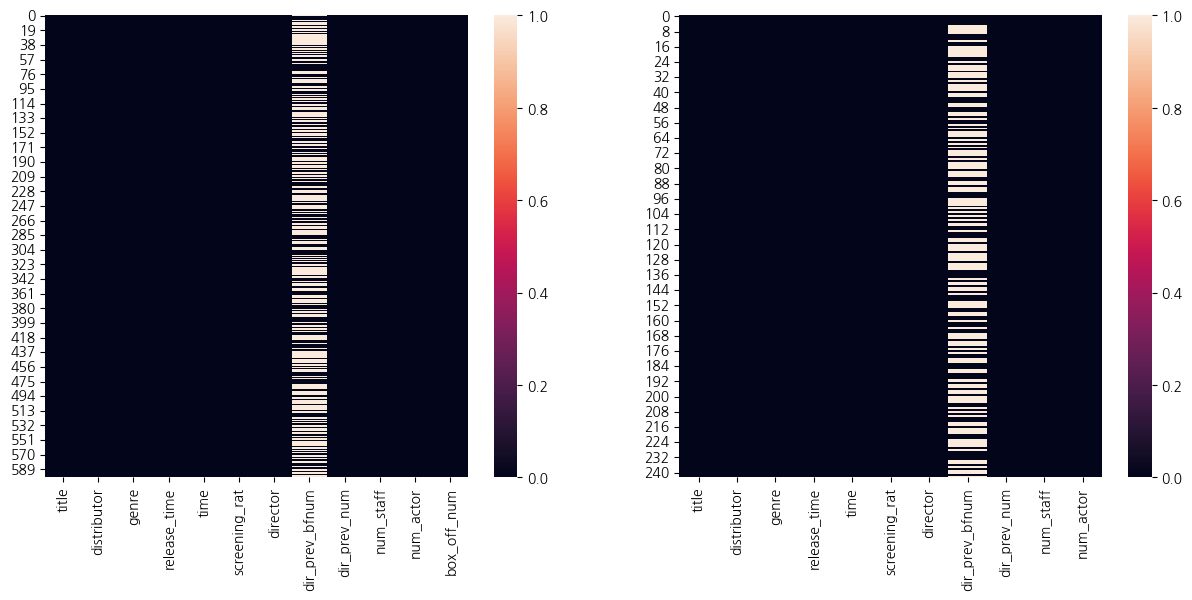

In [34]:
# 결측치를 시각화해봅니다
fig, axes = plt.subplots(nrows=1 , ncols=2 , figsize=(15,6))
sns.heatmap(train.isnull(), ax=axes[0])
sns.heatmap(test.isnull(), ax=axes[1])

`dir_prev_bfnum`은 해당 감독이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수부분에 결측치가 존재함  
관객수가 알려지지 않은 부분이 결측치로 존재하는거라, 정보가 없다라는 정보 그 자체로 사용해도 괜찮을꺼 같음

#### distributor: 배급사

In [40]:
train['distributor'] = train.distributor.str.replace("(주)", '')
test['distributor'] = test.distributor.str.replace("(주)", '')

In [43]:
train

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387
...,...,...,...,...,...,...,...,...,...,...,...,...
595,해무,NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,3833.00,1,510,7,1475091
596,파파로티,쇼박스,드라마,2013-03-14,127,15세 관람가,윤종찬,496061.00,1,286,6,1716438
597,살인의 강,마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,NaN,0,123,4,2475
598,악의 연대기,CJ엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,NaN,0,431,4,2192525


In [12]:
# \(|주|\) 는 데이터에서 제거해줍니다
train['distributor'] = train.distributor.str.replace("(주)", '')
test['distributor'] = test.distributor.str.replace("(주)", '')

<AxesSubplot: xlabel='distributor', ylabel='count'>

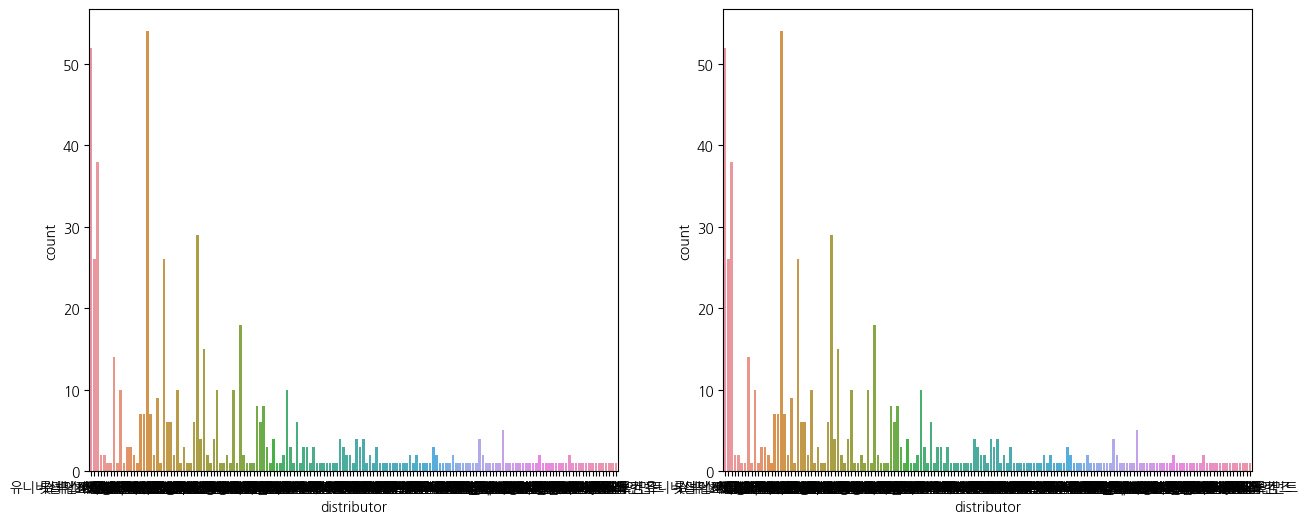

In [47]:
fig, axes = plt.subplots(nrows=1 , ncols=2 , figsize=(15,6))
sns.countplot(data=train , x='distributor',ax = axes[0])
sns.countplot(data=train , x='distributor',ax = axes[1])

In [42]:
# 정규 표현식으로 문자와 숫자만 
train["distributor"] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

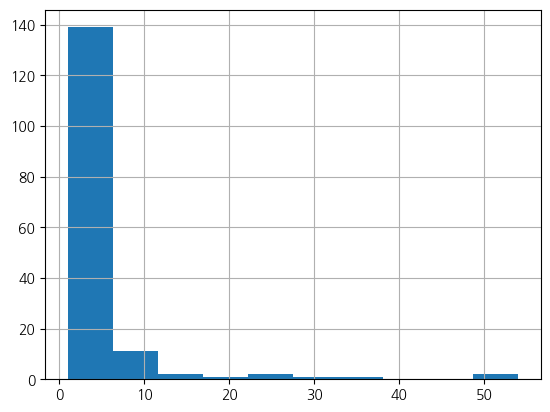

In [48]:
_ = train["distributor"].value_counts().hist()

In [94]:
df_dist = pd.DataFrame(train['distributor'].value_counts()) > 15
df_dist.loc[df_dist['distributor']==True].index


Index(['CJ엔터테인먼트', '롯데엔터테인먼트', 'NEW', '마운틴픽쳐스', '인디스토리', '쇼박스', '시네마달'], dtype='object')

In [99]:
# 배급사의 개수를 이용해 소형, 중대형으로 분리하기 위한 함수를 작성합니다
# 15개 이하면 소형, 이외면 중대형으로 분류 합니다
def distributor_band(x):
    df_dist = pd.DataFrame(train['distributor'].value_counts()) > 15
    df = df_dist.loc[df_dist['distributor']==True].index
    
    if x in df:
        return '중대형'
    else:
        return '소형'

In [100]:
train["distributor"].apply(distributor_band).value_counts()

소형     357
중대형    243
Name: distributor, dtype: int64

In [102]:
test["distributor"].apply(distributor_band).value_counts()

소형     133
중대형    110
Name: distributor, dtype: int64

In [101]:
train

,distributor,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,rank_genre,year,month,day,dayofweek
0,롯데엔터테인먼트,96,청소년 관람불가,0.00,0,91,2,23398,2,2012,11,22,3
1,쇼박스,130,청소년 관람불가,1161602.50,2,387,3,7072501,1,2015,11,19,3
2,쇼박스,123,15세 관람가,220775.25,4,343,4,6959083,2,2013,6,5,2
3,NEW,101,전체 관람가,23894.00,2,20,6,217866,4,2012,7,12,3
4,쇼박스미디어플렉스,108,15세 관람가,1.00,1,251,2,483387,4,2010,11,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,NEW,111,청소년 관람불가,3833.00,1,510,7,1475091,5,2014,8,13,2
596,쇼박스,127,15세 관람가,496061.00,1,286,6,1716438,5,2013,3,14,3
597,마운틴픽쳐스,99,청소년 관람불가,0.00,0,123,4,2475,6,2010,9,30,3
598,CJ엔터테인먼트,102,15세 관람가,0.00,0,431,4,2192525,1,2015,5,14,3


In [103]:
# 위 함수를 train과 test에 모두 적용합니다
train['distributor_band'] = train['distributor'].apply(distributor_band)
test['distributor_band'] = test['distributor'].apply(distributor_band)

In [105]:
train['distributor_band'].value_counts()

소형     357
중대형    243
Name: distributor_band, dtype: int64

In [106]:
test['distributor_band'].value_counts()

소형     133
중대형    110
Name: distributor_band, dtype: int64

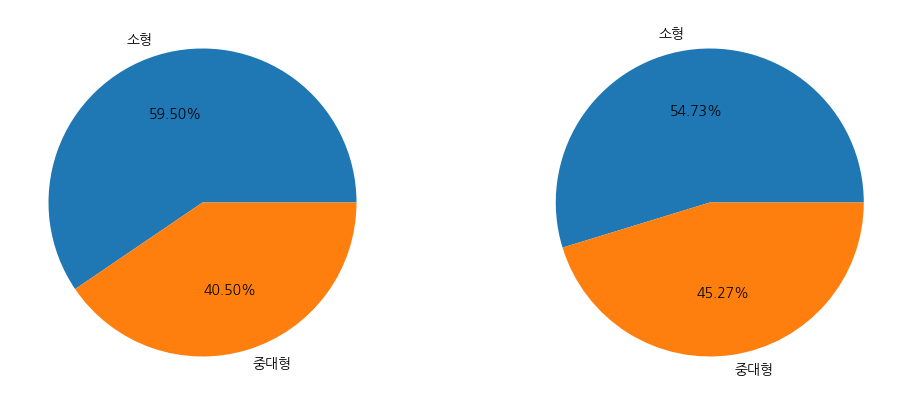

In [107]:
# pie 차트는 다음과 같이 그릴 수 있습니다
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].pie(train["distributor_band"].value_counts().values, labels=train["distributor_band"].value_counts().index, autopct="%.2f%%")
ax[1].pie(test["distributor_band"].value_counts().values, labels=test["distributor_band"].value_counts().index, autopct="%.2f%%")
plt.show()

#### genre: 장르


In [58]:
train.groupby("genre")["box_off_num"].mean().sort_values()

genre
뮤지컬         6627.00
다큐멘터리      67172.26
서스펜스       82611.00
애니메이션     181926.67
멜로/로맨스    425968.04
미스터리      527548.18
공포        590832.52
드라마       625689.79
코미디      1193914.00
SF       1788345.69
액션       2203974.07
느와르      2263695.11
Name: box_off_num, dtype: float64

In [59]:
# 위에서 구한 장르로
# rank 딕셔너리를 하드코딩합니다
# 인코딩하는 과정입니다
rank = {'느와르' : 1, '액션' : 2, 'SF' : 3, '코미디' : 4, '드라마' : 5, '공포' : 6, 
                 '미스터리' : 7, '멜로/로맨스' : 8, '애니메이션' : 9, '서스펜스' : 10, '다큐멘터리': 11, '뮤지컬' : 12}

In [60]:
train["rank_genre"] = train["genre"].apply(lambda x: rank[x])
test["rank_genre"] = test["genre"].apply(lambda x: rank[x])

In [75]:
# 인코딩 전의 장르 컬럼은 버려줍니다
train.drop(columns='genre',inplace=True)
test.drop(columns='genre',inplace=True)

### release_time: 개봉일

In [73]:
train

,title,distributor,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,rank_genre,year,month,day,dayofweek
0,개들의 전쟁,롯데엔터테인먼트,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,2,2012,11,22,3
1,내부자들,쇼박스,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,1,2015,11,19,3
2,은밀하게 위대하게,쇼박스,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,2,2013,6,5,2
3,나는 공무원이다,NEW,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866,4,2012,7,12,3
4,불량남녀,쇼박스미디어플렉스,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387,4,2010,11,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,해무,NEW,2014-08-13,111,청소년 관람불가,심성보,3833.00,1,510,7,1475091,5,2014,8,13,2
596,파파로티,쇼박스,2013-03-14,127,15세 관람가,윤종찬,496061.00,1,286,6,1716438,5,2013,3,14,3
597,살인의 강,마운틴픽쳐스,2010-09-30,99,청소년 관람불가,김대현,NaN,0,123,4,2475,6,2010,9,30,3
598,악의 연대기,CJ엔터테인먼트,2015-05-14,102,15세 관람가,백운학,NaN,0,431,4,2192525,1,2015,5,14,3


In [76]:
test

,title,distributor,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,rank_genre,year,month,day,dayofweek
0,용서는 없다,시네마서비스,2012-11-22,125,청소년 관람불가,김형준,300529.00,2,304,3,1,2012,11,22,3
1,아빠가 여자를 좋아해,쇼박스,2015-11-19,113,12세 관람가,이광재,342700.25,4,275,3,8,2015,11,19,3
2,하모니,CJ엔터테인먼트,2013-06-05,115,12세 관람가,강대규,4206610.67,3,419,7,5,2013,6,5,2
3,의형제,쇼박스,2012-07-12,116,15세 관람가,장훈,691342.00,2,408,2,2,2012,7,12,3
4,평행 이론,CJ엔터테인먼트,2010-11-04,110,15세 관람가,권호영,31738.00,1,380,1,6,2010,11,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,해에게서 소년에게,디씨드,2012-10-18,78,15세 관람가,안슬기,2590.00,1,4,4,5,2012,10,18,3
239,울보 권투부,인디스토리,2015-03-05,86,12세 관람가,이일하,NaN,0,18,2,11,2015,3,5,3
240,어떤살인,컨텐츠온미디어,2014-03-27,107,청소년 관람불가,안용훈,NaN,0,224,4,1,2014,3,27,3
241,말하지 못한 비밀,씨타마운틴픽쳐스,2014-08-14,102,청소년 관람불가,송동윤,50699.00,1,68,7,5,2014,8,14,3


In [67]:
# 개봉일의 데이터타입은 datetime으로 변경합니다
train["release_time"] = pd.to_datetime(train["release_time"])
test["release_time"] = pd.to_datetime(train["release_time"])

In [68]:
# 연 월 일 요일 파생 변수를 train과 test에 생성합니다
train["year"] =train["release_time"].dt.year
train["month"] =train["release_time"].dt.month
train["day"] =train["release_time"].dt.day
train["dayofweek"] =train["release_time"].dt.dayofweek


In [70]:
test["year"] =test["release_time"].dt.year
test["month"] =test["release_time"].dt.month
test["day"] =test["release_time"].dt.day
test["dayofweek"] =test["release_time"].dt.dayofweek

In [77]:
# 기존 데이터는 삭제합니다
train.drop(columns='release_time',inplace=True)
test.drop(columns='release_time',inplace=True)

<AxesSubplot: xlabel='dayofweek', ylabel='count'>

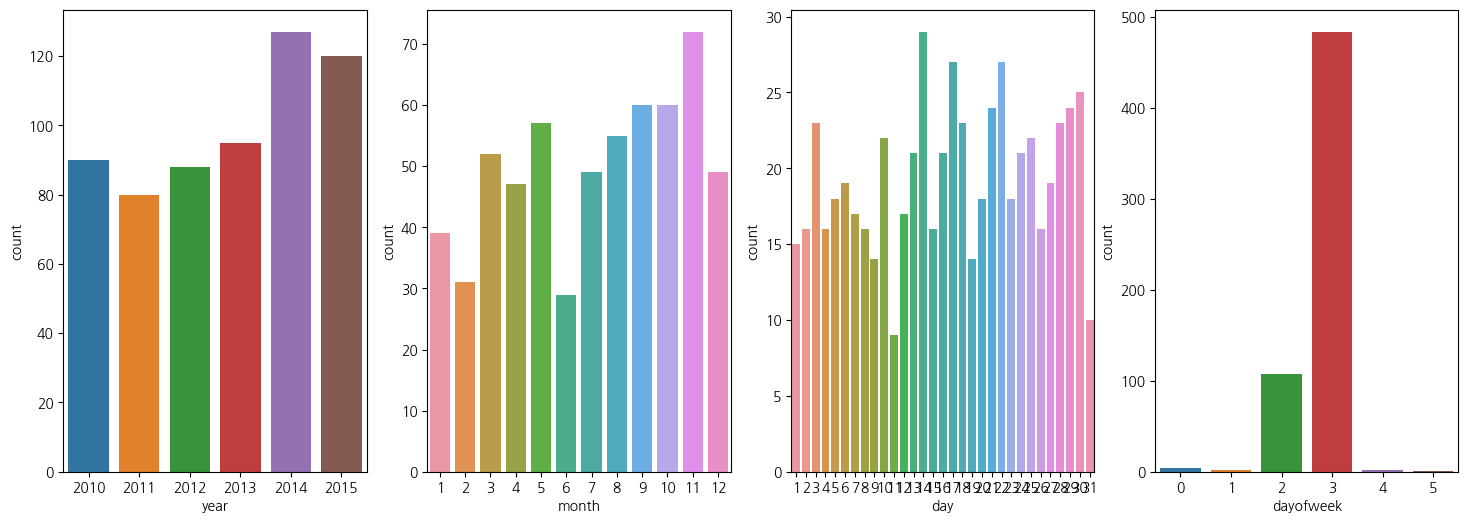

In [85]:
# 요일별로 시각화 해봅니다
fig, axes = plt.subplots(1, 4, figsize=(18,6))
sns.countplot(data=train, x='year',ax=axes[0])
sns.countplot(data=train, x='month',ax=axes[1])
sns.countplot(data=train, x='day',ax=axes[2])
sns.countplot(data=train, x='dayofweek',ax=axes[3])

수요일, 목요일에 개봉한 영화들이 많고 목요일에 개봉한 영화가 유독 많음

## Train

In [86]:
# 제목과 감독 데이터는 버려줍니다
train = train.drop(['title', 'director'],axis = 1)
test = test.drop(['title', 'director'],axis = 1)

In [88]:
train["dir_prev_bfnum"].fillna(0, inplace=True)
test["dir_prev_bfnum"].fillna(0, inplace=True)

In [109]:
train = train.drop(['distributor'],axis = 1)
test = test.drop(['distributor'],axis = 1)

In [113]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   time                    600 non-null    int64  
 1   dir_prev_bfnum          600 non-null    float64
 2   dir_prev_num            600 non-null    int64  
 3   num_staff               600 non-null    int64  
 4   num_actor               600 non-null    int64  
 5   box_off_num             600 non-null    int64  
 6   rank_genre              600 non-null    int64  
 7   year                    600 non-null    int64  
 8   month                   600 non-null    int64  
 9   day                     600 non-null    int64  
 10  dayofweek               600 non-null    int64  
 11  distributor_band_소형     600 non-null    uint8  
 12  distributor_band_중대형    600 non-null    uint8  
 13  screening_rat_12세 관람가   600 non-null    uint8  
 14  screening_rat_15세 관람가   600 non-null    ui

In [115]:
# 범주형 데이터들을 인코딩해줍니다
train = pd.get_dummies(columns=['distributor_band','screening_rat'],data=train)
test = pd.get_dummies(columns=['distributor_band','screening_rat'],data=test)


In [116]:
train.columns

Index(['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor',
       'box_off_num', 'rank_genre', 'year', 'month', 'day', 'dayofweek',
       'distributor_band_소형', 'distributor_band_중대형', 'screening_rat_12세 관람가',
       'screening_rat_15세 관람가', 'screening_rat_전체 관람가',
       'screening_rat_청소년 관람불가'],
      dtype='object')

In [120]:
# 피처와 라벨을 구합니다
features = ['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor',
        'rank_genre', 'year', 'month', 'day', 'dayofweek',
       'distributor_band_소형', 'distributor_band_중대형', 'screening_rat_12세 관람가',
       'screening_rat_15세 관람가', 'screening_rat_전체 관람가',
       'screening_rat_청소년 관람불가']
features

['time',
 'dir_prev_bfnum',
 'dir_prev_num',
 'num_staff',
 'num_actor',
 'rank_genre',
 'year',
 'month',
 'day',
 'dayofweek',
 'distributor_band_소형',
 'distributor_band_중대형',
 'screening_rat_12세 관람가',
 'screening_rat_15세 관람가',
 'screening_rat_전체 관람가',
 'screening_rat_청소년 관람불가']

In [119]:
label = 'box_off_num'
label

'box_off_num'

### Log Scale

In [146]:
# 등장 배우의 수에 로그 스케일을 적용합니다
train['num_actor_log1p'] = np.log(train['num_actor']+1)

In [121]:
X_train, X_val, y_train, y_val = train_test_split(train[features], train[label], test_size=0.15)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_val: {X_val.shape}\ny_val: {y_val.shape}")

X_train: (510, 16)
y_train: (510,)
X_val: (90, 16)
y_val: (90,)


In [122]:
test.shape

(243, 16)

### Random Forest

In [125]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42, n_jobs=-1)
model

RandomForestRegressor(n_jobs=-1, random_state=42)

In [124]:
X_train = train[features]
y_train = train[label]
X_test = test[features]

In [127]:
model.fit(X_train,y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [140]:
from sklearn.model_selection import cross_val_predict

y_valid_pred = cross_val_predict(model, X_train , y_train , cv=5, n_jobs=-1, verbose=2)
y_valid_pred[:10]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


array([  16618.1 , 3606627.15, 3049062.41,   44527.88,  542940.64,
        800938.71,   38602.01, 1180703.02,  318218.43,   19209.43])

In [141]:
mse = ((y_train - y_valid_pred) ** 2).mean()
mse

2248357006780.1123

In [143]:
print('rmse: ',np.sqrt(mse))

rmse:  1499452.2355780834


rmse: 1377636.6138653848


<AxesSubplot: >

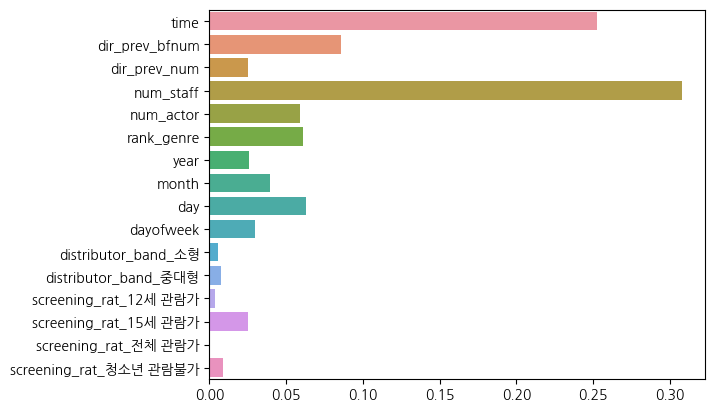

In [144]:
sns.barplot(x=model.feature_importances_, y=model.feature_names_in_)

### XGBoost

In [145]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators=100)
xgb_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [147]:
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [148]:
from sklearn.model_selection import cross_val_predict

y_valid_pred = cross_val_predict(xgb_model, X_train , y_train , cv=5, n_jobs=-1, verbose=2)
y_valid_pred[:10]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


array([   9897.953, 4322659.5  , 8797684.   ,   37081.594,  563038.44 ,
       1168631.4  ,   49906.383,  800867.25 ,  977289.25 ,   48548.79 ],
      dtype=float32)

In [149]:
mse = ((y_train - y_valid_pred) ** 2).mean()
mse

2549495003426.7417

In [150]:
print('rmse: ',np.sqrt(mse))

rmse:  1596713.8138773465


<AxesSubplot: >

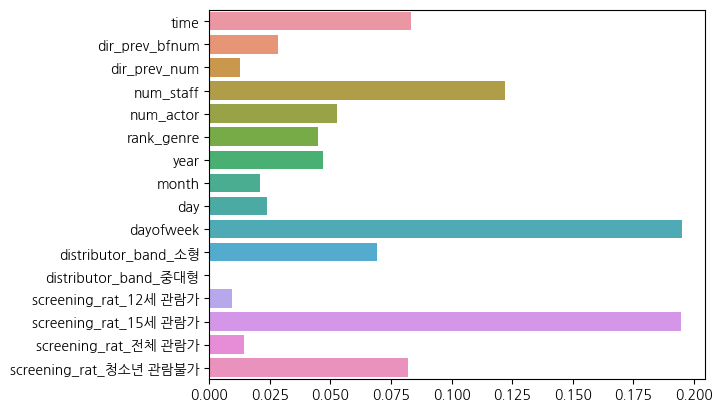

In [153]:
sns.barplot(x=xgb_model.feature_importances_, y=xgb_model.feature_names_in_)

### LightGBM

In [154]:
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor(n_estimators=100, n_jobs=-1)
lgbm_model

LGBMRegressor()

In [155]:
lgbm_model.fit(X_train,y_train)

LGBMRegressor()

In [156]:
from sklearn.model_selection import cross_val_predict

y_valid_pred = cross_val_predict(lgbm_model, X_train , y_train , cv=5, n_jobs=-1, verbose=2)
y_valid_pred[:10]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


array([  47017.25903959, 3890900.63080636, 5584769.65096789,
          7666.94621921,  600569.27033109, 1671024.87718354,
        240756.37637084,  689465.75757879, 1058265.05163088,
       -140501.88451287])

In [157]:
mse = ((y_train - y_valid_pred) ** 2).mean()
mse

2144241088367.8367

In [158]:
print('rmse: ',np.sqrt(mse))

rmse:  1464322.7405076507
